# Environment Setup 

Include files

# Note:

Please download the zip file from the following URL and add the extracted files to the Runtime.
(https://drive.google.com/file/d/1qe41S_s_H9cxfZEuRoin03WTzZ11uMFP/view?usp=share_link)

In [ ]:
# include files
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import loader
import os
import matplotlib.pyplot as plt 
import traceback
import random
from torch.autograd import Variable
import pandas as pd
import math

LSTM model class

Below diagram shows the flow of our data in a simple LSMT model. 
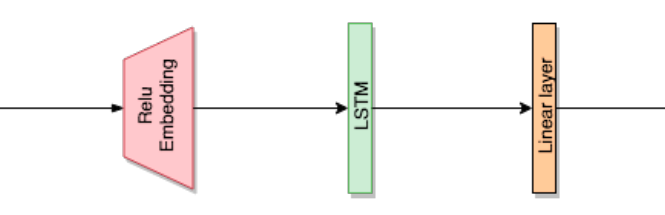

This model has the architecure shown in Fig 3. It has an embedding dimension of 64 which is fed in to LSTM cell. 

We first input the coordiantes to a dense layer which maps the data
to a higher dimensionality. 

Hidden state dimension of 128 is used for the LSTM cell. The hidden layer in LSTM captures the latent unformation of that agent. 

Dropout of 0.5 is applied to dense layer. The embedding layer then uses ReLU non
linearity before the features are fed into RNN cells. 

Learning rate has been taken as 0.0003. Optimizer used is Adam

In [ ]:
class VanillaLSTMNet(nn.Module):
    def __init__(self):

        super(VanillaLSTMNet, self).__init__()
        
        """
        Inputs to the LSTMCell's are (input, (h_0, c_0)):
        1. input of shape (batch, input_size): tensor containing input features
        2a. h_0 of shape (batch, hidden_size): tensor containing the initial hidden state for each element in the batch.
        2b. c_0 of shape (batch, hidden_size): tensor containing the initial cell state for each element in the batch.
        
        Outputs: h_1, c_1
        1. h_1 of shape (batch, hidden_size): tensor containing the next hidden state for each element in the batch
        2. c_1 of shape (batch, hidden_size): tensor containing the next cell state for each element in the batch
        """
        
        # set parameters for network architecture
        self.embedding_size = 64
        self.input_size = 2 
        self.output_size = 2
        self.dropout_prob = 0.5 
        
        # linear layer to embed the input position
        self.input_embedding_layer = nn.Linear(self.input_size, self.embedding_size)
        
        # define lstm cell
        self.lstm_cell = nn.LSTMCell(self.embedding_size, self.embedding_size)

        # linear layer to map the hidden state of LSTM to output
        self.output_layer = nn.Linear(self.embedding_size, self.output_size)
        
        # ReLU and dropout unit
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(self.dropout_prob)
        
        pass    
        
    def forward(self, observed_batch, pred_len = 0):

        """
        this function takes the input sequence and predicts the output sequence. 
        
            args
                observed_batch (torch.Tensor) : input batch with shape <seq length x num pedestrians x number of dimensions>
                pred_len (int) : length of the sequence to be predicted.

        """

        output_seq = []

        # inputs to lstm cell layer
        ht = torch.zeros(observed_batch.size(1), self.embedding_size, dtype=torch.float)
        ct = torch.zeros(observed_batch.size(1), self.embedding_size, dtype=torch.float)
        
        # the data is in the form of fram number, pedestrian id, spatial coordiantes
        seq, peds, coords = observed_batch.shape

        # feeding the observed trajectory to the network
        for step in range(seq):
            observed_step = observed_batch[step, :, :]
            # first input to embedding layer
            lin_out = self.input_embedding_layer(observed_step.view(peds,2))
            # then input to dropout and rely embedding
            input_embedded=self.dropout(self.relu(lin_out))
            # input to lstm layer
            ht,ct = self.lstm_cell(input_embedded, (ht,ct))
            # Linear layer
            out = self.output_layer(ht)

        # getting the predicted trajectory from the pedestrian 
        for i in range(pred_len):
            lin_out = self.input_embedding_layer(out)
            input_embedded=self.dropout(self.relu(lin_out))
            ht,ct = self.lstm_cell(input_embedded, (ht,ct))
            out = self.output_layer(ht)
            output_seq += [out]
            
        output_seq = torch.stack(output_seq).squeeze() # convert list to tensor
        return output_seq

Training loss Computation

In [ ]:
def computeLSTMTrainingLoss(vanilla_lstm_net,pred_len=0):
    use_cuda = False
    test_data_dir = "./test"

    # retrieve dataloader
    dataset, dataloader = loader.data_loader(test_data_dir)

    # define parameters for training and testing loops

    # MSE loss has been used as optimizer
    criterion = nn.MSELoss() 

    # initialize lists for capturing losses
    test_loss = []
    test_avgD_error=[]
    test_finalD_error=[]
    num_test_peds=0 #counter for number of pedestrians in the test dataset
    # now, test the model
    for i, batch in enumerate(dataloader):
        if(use_cuda): #when use_cuda has been mentioned in the argument
            test_observed_batch = batch[0].cuda()
            test_target_batch = batch[1].cuda()[0:pred_len]
        else: #when use_cuda has not been mentioned in the argument
            test_observed_batch = batch[0]
            test_target_batch = batch[1][0:pred_len]

        out = vanilla_lstm_net(test_observed_batch, pred_len=pred_len) # forward pass of lstm network for training
        print(out.shape)
        print(test_target_batch.shape)

        cur_test_loss = criterion(out, test_target_batch) # calculate MSE loss
        test_loss.append(cur_test_loss.item())
        out1=out
        target_batch1 = test_target_batch  #making a copy of the tensors to convert them to array
        if(use_cuda): #to transfer the tensors back to CPU if cuda was used
            out1 = out1.cpu()
            target_batch1 = target_batch1.cpu()

        seq, peds, coords = test_target_batch.shape
        num_test_peds+=peds
        avgD_error=(np.sum(np.sqrt(np.square(out1[:,:,0].detach().numpy()-target_batch1[:,:,0].detach().numpy())+
            np.square(out1[:,:,1].detach().numpy()-target_batch1[:,:,1].detach().numpy()))))/(pred_len*peds)
        test_avgD_error.append(avgD_error)

        # final displacement error
        finalD_error=(np.sum(np.sqrt(np.square(out1[pred_len-1,:,0].detach().numpy()-target_batch1[pred_len-1,:,0].detach().numpy())+
            np.square(out1[pred_len-1,:,1].detach().numpy()-target_batch1[pred_len-1,:,1].detach().numpy()))))/peds
        test_finalD_error.append(finalD_error)
                
    avg_testloss = sum(test_loss)/len(test_loss)
    avg_testD_error=sum(test_avgD_error)/len(test_avgD_error)
    avg_testfinalD_error=sum(test_finalD_error)/len(test_finalD_error)
    print("============= Average test loss:", avg_testloss, "====================")


    return avg_testloss, avg_testD_error,avg_testfinalD_error,num_test_peds

Training model

In [ ]:
def trainLSTMModel():
    """
    
    """
    # reading parameters for training and testing loops
    num_epoch = 20
    pred_len = 8
    learning_rate = 0.0007
    obs_len = 12
    use_cuda = False
    data_dir = "./train"
    # retrieve dataloader
    _, dataloader = loader.data_loader( data_dir )

    ''' define the network, optimizer and criterion '''
    name = "eth" # to add to the name of files
    vanilla_lstm_net = VanillaLSTMNet()
    if(use_cuda):
        vanilla_lstm_net.cuda()

    # Loss function used is MSE loss for Vanilla LSTM
    criterion = nn.MSELoss()
    # Optimizer used is Adam
    optimizer = optim.Adam(vanilla_lstm_net.parameters(), lr=learning_rate)

    # initialize lists for capturing losses/errors
    train_loss = []
    test_loss = []
    avg_train_loss = []
    avg_test_loss = []
    train_avgD_error=[]
    train_finalD_error=[]
    avg_train_avgD_error=[]
    avg_train_finalD_error=[]
    test_finalD_error=[]
    test_avgD_error=[]
    std_train_loss = []
    num_train_peds=[] #counter for number of pedestrians taken for each epoch


    '''training loop'''
    for i in range(num_epoch):
       
        print('======================= Epoch: {cur_epoch} / {total_epochs} =======================\n'.format(cur_epoch=i, total_epochs=num_epoch))
        
        def closure():
            train_peds=0 #counter for number of pedestrians taken for each epoch
            for i, batch in enumerate(dataloader):
                if(use_cuda):
                    train_batch = batch[0].cuda()
                    target_batch = batch[1].cuda()[0:pred_len]
                else:
                    train_batch = batch[0]
                    target_batch = batch[1][0:pred_len]

                seq, peds, coords = train_batch.shape # q is number of pedestrians 
                train_peds+=peds #keeping a count of the number of peds in the data
                out = vanilla_lstm_net(train_batch, pred_len=pred_len) # forward pass of lstm network for training
                optimizer.zero_grad() # zero out gradients
                cur_train_loss = criterion(out, target_batch) # calculate MSE loss
                print('Current training loss: {}'.format(cur_train_loss.item())) # print current training loss
                
                #calculating average deisplacement error
                out1=out
                target_batch1=target_batch  #making a copy of the tensors to convert them to array
                if(use_cuda):
                    out1=out1.cpu()
                    target_batch1=target_batch1.cpu()
                
                avgD_error=(np.sum(np.sqrt(np.square(out1[:,:,0].detach().numpy()-target_batch1[:,:,0].detach().numpy())+
                    np.square(out1[:,:,1].detach().numpy()-target_batch1[:,:,1].detach().numpy()))))/(pred_len*peds)
                train_avgD_error.append(avgD_error)

                #calculate final displacement error
                finalD_error=(np.sum(np.sqrt(np.square(out1[pred_len-1,:,0].detach().numpy()-target_batch1[pred_len-1,:,0].detach().numpy())+
                    np.square(out1[pred_len-1,:,1].detach().numpy()-target_batch1[pred_len-1,:,1].detach().numpy()))))/peds
                train_finalD_error.append(finalD_error)

                train_loss.append(cur_train_loss.item())
                cur_train_loss.backward() # backward prop
                optimizer.step() # step like a mini-batch (after all pedestrians)
            num_train_peds.append(train_peds)
            return cur_train_loss

        try:
          optimizer.step(closure) # update weights
        except Exception as e:
          traceback.print_exc()


        # save model at every epoch (uncomment) 
        # torch.save(lstm_net, './saved_models/lstm_model_v3.pt')
        # print("Saved lstm_net!")
        avg_train_loss.append(np.sum(train_loss)/len(train_loss))
        avg_train_avgD_error.append(np.sum(train_avgD_error)/len(train_avgD_error))
        avg_train_finalD_error.append(np.sum(train_finalD_error)/len(train_finalD_error))   
        std_train_loss.append(np.std(np.asarray(train_loss)))
        train_loss = [] # empty train loss

        print("$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$")
        print("average train loss: {}".format(avg_train_loss))
        print("average std loss: {}".format(std_train_loss))
        avgTestLoss, avgD_test, finalD_test, num_test_peds = computeLSTMTrainingLoss(vanilla_lstm_net, pred_len)
        avg_test_loss.append(avgTestLoss)
        test_finalD_error.append(finalD_test)
        test_avgD_error.append(avgD_test)
        print("test finalD error: ",finalD_test)
        print("test avgD error: ",avgD_test)


    '''after running through epochs, save your model and visualize.
       then, write your average losses and standard deviations of 
       losses to a text file for record keeping.'''

    save_path = os.path.join('./saved_models/', 'lstm_model_'+name+'_lr_' + str(learning_rate) + '_epoch_' + str(num_epoch) + '_predlen_' + str(pred_len) +'_obs'+str(obs_len)+ '.pt')
    # torch.save(lstm_net, './saved_models/lstm_model_lr001_ep20.pt')
    torch.save(vanilla_lstm_net, save_path)
    print("saved lstm_net! location: " + save_path)

    ''' visualize losses vs. epoch'''
    plt.figure() # new figure
    plt.title("Average train loss vs {} epochs".format(num_epoch))
    plt.plot(avg_train_loss,label='avg train_loss') 
    plt.plot(avg_test_loss,color='red',label='avg test_loss')
    plt.legend()
    plt.savefig("./saved_figs/" + "lstm_"+name+"_avgtrainloss_lr_"+ str(learning_rate) + '_epochs_' + str(num_epoch) + '_predlen_' + str(pred_len) +'_obs'+str(obs_len)+  '.png')
    # plt.show()
    # plt.show(block=True)
    
    plt.figure() # new figure
    plt.title("Average and final displacement error {} epochs".format(num_epoch))
    plt.plot(avg_train_finalD_error,label='train:final disp. error') 
    plt.plot(avg_train_avgD_error,color='red',label='train:avg disp. error')
    plt.plot(test_finalD_error,color='green',label='test:final disp. error')
    plt.plot(test_avgD_error,color='black',label='test:avg disp. error')
    plt.ylim((0,10))
    plt.legend()
    # plt.show()
    plt.savefig("./saved_figs/" + "lstm_"+name+"_avg_final_displacement_lr_"+ str(learning_rate) + '_epochs_' + str(num_epoch) + '_predlen_' + str(pred_len) +'_obs'+str(obs_len)+  '.png')

    plt.figure()
    plt.title("Std of train loss vs epoch{} epochs".format(num_epoch))
    plt.plot(std_train_loss)
    plt.savefig("./saved_figs/" + "lstm_"+name+"_stdtrainloss_lr_"+ str(learning_rate) + '_epochs_' + str(num_epoch) + '_predlen_' + str(pred_len) +'_obs'+str(obs_len)+'.png')
    # plt.show(block=True)
    print("saved images for avg training losses! location: " + "./saved_figs")

    # save results to text file
    txtfilename = os.path.join("./txtfiles/", "lstm_"+name+"_avgtrainlosses_lr_"+ str(learning_rate) + '_epochs_' + str(num_epoch) + '_predlen_' + str(pred_len) +'_obs'+str(obs_len)+ ".txt")
    os.makedirs(os.path.dirname("./txtfiles/"), exist_ok=True) # make directory if it doesn't exist
    with open(txtfilename, "w") as f:
        f.write("Number of pedestrians in the traning data: {}\n".format(num_train_peds[-1]))
        f.write("Number of pedestrians in the test dataset: {}\n".format(num_test_peds))
        f.write("\n==============Average train loss vs. epoch:===============\n")
        f.write(str(avg_train_loss))
        f.write("\nepochs: " + str(num_epoch))
        f.write("\n==============Std train loss vs. epoch:===================\n")
        f.write(str(std_train_loss))
        f.write("\n==============Avg test loss vs. epoch:===================\n")
        f.write(str(avg_test_loss))
        f.write("\n==============Avg train displacement error:===================\n")
        f.write(str(avg_train_avgD_error))
        f.write("\n==============Final train displacement error:===================\n")
        f.write(str(avg_train_finalD_error))
        f.write("\n==============Avg test displacement error:===================\n")
        f.write(str(test_avgD_error))
        f.write("\n==============Final test displacement error:===================\n")
        f.write(str(test_finalD_error))
    print("saved average and std of training losses to text file in: ./txtfiles")

    # saving all data files with different prediction lengths and observed lengths for each dataset    
    txtfilename2 = os.path.join("./txtfiles/", "RESULTS_LSTM2"+"_diff_ObsPred_len_lr_"+ str(learning_rate) + '_numepochs_' + str(num_epoch)+ ".txt")
    os.makedirs(os.path.dirname("./txtfiles/"), exist_ok=True) # make directory if it doesn't exist
    with open(txtfilename2,"a+") as g: #opening the file in the append mode
        if(pred_len==2):
            g.write("Dataset: "+name+" ;Number of epochs: {}".format(num_epoch)+"\n")
            g.write("obs_len"+"\t"+"pred_len"+"\t"+"avg_train_loss"+"\t"+"avg_test_loss"+"\t"+"std_train_loss"+"\t"
            	+"avg_train_dispacement"+"\t"+"final_train_displacement"+"\t"+"avg_test_displacement"+"\t"
            	+"final_test_displacement"+"\t"+"Num_train_peds"+"\t"+"Num_Test_peds"+"\n")
        # outputing the current observed length
        g.write(str(obs_len)+"\t")
        # outputing the current prediction length
        g.write(str(pred_len)+"\t")
        #the avg_train_loss after total epochs
        g.write(str(avg_train_loss[-1])+"\t")
        # the avg_test_loss after total epochs
        g.write(str(avg_test_loss[-1])+"\t")
        # the standard deviation of train loss
        g.write(str(std_train_loss[-1])+"\t")
        # the avg train dispacement error
        g.write(str(avg_train_avgD_error[-1])+"\t")
        # the train final displacement error
        g.write(str(avg_train_finalD_error[-1])+"\t")
        # the test avg displacement error
        g.write(str(test_avgD_error[-1])+"\t")
        # the test final displacement error
        g.write(str(test_finalD_error[-1])+"\t")
        # the number of pedestrians in the traininig dataset
        g.write(str(num_train_peds[-1])+"\t")
        # Number of pedestrian sin the training dataset
        g.write(str(num_test_peds)+"\n")
    print("saved all the results to the text file for observed length: {}".format(obs_len))

======================= Epoch: 0 / 20 =======================

out's shape: torch.Size([29, 2])
Current training loss: 17.464862823486328
out's shape: torch.Size([30, 2])
Current training loss: 17.679250717163086
out's shape: torch.Size([30, 2])
Current training loss: 19.438451766967773
out's shape: torch.Size([31, 2])
Current training loss: 11.882057189941406
out's shape: torch.Size([35, 2])
Current training loss: 14.681586265563965
out's shape: torch.Size([27, 2])
Current training loss: 12.800923347473145
out's shape: torch.Size([37, 2])
Current training loss: 11.192855834960938
out's shape: torch.Size([36, 2])
Current training loss: 15.286983489990234
out's shape: torch.Size([31, 2])
Current training loss: 16.389678955078125
out's shape: torch.Size([26, 2])
Current training loss: 11.892496109008789
out's shape: torch.Size([35, 2])
Current training loss: 10.695015907287598
out's shape: torch.Size([33, 2])
Current training loss: 15.57330322265625
out's shape: torch.Size([37, 2])
Curre

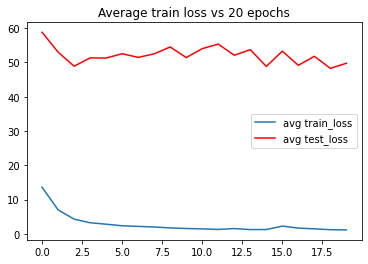

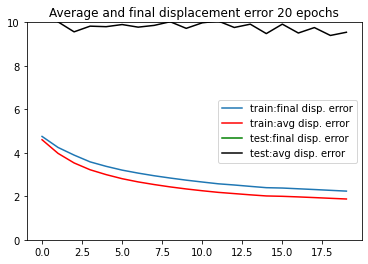

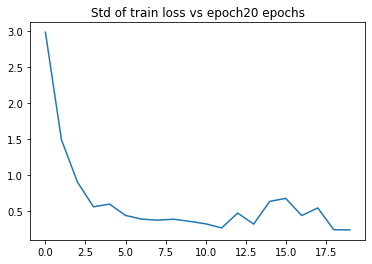

In [ ]:
trainLSTMModel()

Testing model

In [ ]:
def testLSTMModel():
    """
    this function is for testing any model and calculate average test loss
    """
    # loading model from test/model data folder
    vanilla_lstm_net = torch.load("vanilla_lstm_model_lr_0.0017_epoch_100_predlen_8_batchsize_5.pt")
    # evaluation mode. this dropout layers, batchnorm layers are turned off during this mode
    vanilla_lstm_net.eval()

    # 
    test_data_dir = os.path.join( "./test" )

    # retrieve dataloader
    _, dataloader = loader.data_loader(test_data_dir)

    # define parameters for training and testing loops
    pred_len = 8
    # MSE loss is used as loss
    criterion = nn.MSELoss()

    # initialize lists for capturing losses
    test_loss = []

    # testing the model
    for _, batch in enumerate(dataloader):
      # get the observed trajectories in this batch of pedestrians
      test_observed_batch = batch[0]
      # get the ground truth of the future trajectories in this batch of pedestrians, truncating upto prediction length
      test_target_batch = batch[1][0:pred_len]

      # forward pass of lstm network for training
      out = vanilla_lstm_net(test_observed_batch, pred_len=pred_len)
      print("out's shape:", out.shape)
      # calculate MSE loss
      cur_test_loss = criterion(out, test_target_batch)
      # print current test loss
      print('Current test loss: {}'.format(cur_test_loss.item()))
      # appending current loss to test loss list
      test_loss.append(cur_test_loss.item())

    # average loss calcuated using total loss list
    avg_testloss = sum(test_loss)/len(test_loss)
    print("========== Average test loss:", avg_testloss, "==========")

In [ ]:
testLSTMModel()

/usr/local/lib/python3.8/dist-packages/torch/serialization.py:834: UserWarning: Couldn't retrieve source code for container of type VanillaLSTMNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.8/dist-packages/torch/serialization.py:868: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTMCell' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChange

out's shape: torch.Size([25, 2])
out's shape: torch.Size([8, 25, 2])
Current test loss: 2.2613534927368164
out's shape: torch.Size([28, 2])
out's shape: torch.Size([8, 28, 2])
Current test loss: 2.3766849040985107
out's shape: torch.Size([26, 2])
out's shape: torch.Size([8, 26, 2])
Current test loss: 3.404384136199951
out's shape: torch.Size([28, 2])
out's shape: torch.Size([8, 28, 2])
Current test loss: 0.41927316784858704
out's shape: torch.Size([26, 2])
out's shape: torch.Size([8, 26, 2])
Current test loss: 3.668057918548584
out's shape: torch.Size([24, 2])
out's shape: torch.Size([8, 24, 2])
Current test loss: 2.597433090209961
out's shape: torch.Size([24, 2])
out's shape: torch.Size([8, 24, 2])
Current test loss: 2.506322145462036
========== Average test loss: 2.4619298364434923 ==========


Visualizing model

In [ ]:
def visualizeLSTM():
    '''
    This function is to plot our predictions against ground truth data
    It plots observed trajectory, predicted output trajectory, and ground truth future trajectory for 12 pedestrians om frames taken from test dataset
    '''
    # get prediction length value
    pred_len = 8
    # get test directory value
    test_data_dir = os.path.join( "./test" )
    
    # loading the lstm model
    lstm_net = torch.load( "vanilla_lstm_model_lr_0.0017_epoch_100_predlen_8_batchsize_5.pt" )
    lstm_net.eval()

    # loading test directory
    _, dataloader = loader.data_loader(test_data_dir)

    # x,y labels for plotting data
    plt.xlabel("X coordinates of pedestrians")
    plt.ylabel("Y coordinates of pedestrians")

    # Testing the model
    for _, batch in enumerate(dataloader):
        # get the observed trajectories in this batch of pedestrians
        test_observed_batch = batch[0]
        # get the ground truth of the future trajectories in this batch of pedestrians
        test_target_batch = batch[1]
        
        # forward pass of lstm network for training
        out = lstm_net(test_observed_batch, pred_len=pred_len)
        # get the frame numbers from the output of lstm model
        s,_,_= out.shape
        # getting numpy array from tensor out
        out1 = out.detach().numpy()
        # converting tensor test_target_batch to numpy
        target1 = test_target_batch.detach().numpy()
        # converting tensor test_observed_batch to numpy
        observed1 = test_observed_batch.detach().numpy()
        
        # printing shapes of observed, target, and output of lstm model
        print("observed 1 shape:",observed1.shape)
        print("target1 shape:", target1.shape)
        print("out 1 shape", out1.shape)
        
        # stacking observed trajectory and output trajectory together for plotting
        out2 = np.vstack((observed1,out1))
        # stacking observed trajectory and ground truth future trajectory together for plotting
        target2 = np.vstack((observed1,target1))
        print("out2 shape",out2.shape)
        
        # plotting observed trajectory, output predicted trajectory, and ground truth trajectory on the same plot for 12 pedestrians id
        for ped_id in range(12):
            plt.plot(observed1[:,ped_id,0], observed1[:,ped_id,1], color='b', marker='o', linewidth=5, markersize=12)
            plt.plot(target2[s-1:s+pred_len,ped_id,0], target2[s-1:s+pred_len,ped_id,1], color='red', marker='o', linewidth=5, markersize=12)
            plt.plot(out2[s-1:s+pred_len,ped_id,0], out2[s-1:s+pred_len,ped_id,1], color='g', marker='o', linewidth=5, markersize=12)
        
        plt.legend(["Observed","Ground Truth","Predicted"])
        plt.show(block=True)

out's shape: torch.Size([25, 2])
observed 1 shape: (8, 25, 2)
target1 shape: (12, 25, 2)
out 1 shape (8, 25, 2)
out2 shape (16, 25, 2)


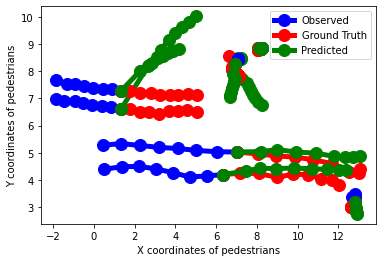

out's shape: torch.Size([27, 2])
observed 1 shape: (8, 27, 2)
target1 shape: (12, 27, 2)
out 1 shape (8, 27, 2)
out2 shape (16, 27, 2)


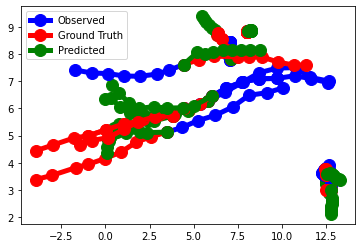

out's shape: torch.Size([27, 2])
observed 1 shape: (8, 27, 2)
target1 shape: (12, 27, 2)
out 1 shape (8, 27, 2)
out2 shape (16, 27, 2)


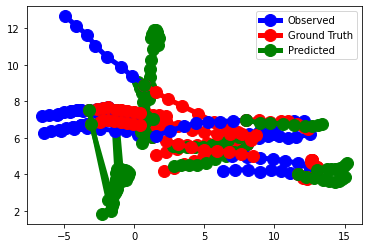

out's shape: torch.Size([25, 2])
observed 1 shape: (8, 25, 2)
target1 shape: (12, 25, 2)
out 1 shape (8, 25, 2)
out2 shape (16, 25, 2)


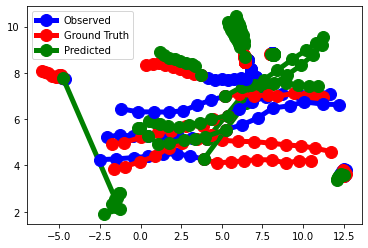

out's shape: torch.Size([28, 2])
observed 1 shape: (8, 28, 2)
target1 shape: (12, 28, 2)
out 1 shape (8, 28, 2)
out2 shape (16, 28, 2)


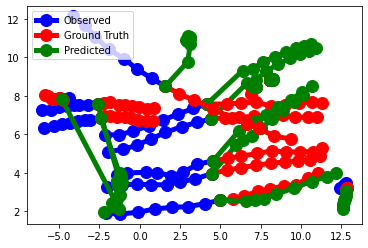

out's shape: torch.Size([26, 2])
observed 1 shape: (8, 26, 2)
target1 shape: (12, 26, 2)
out 1 shape (8, 26, 2)
out2 shape (16, 26, 2)


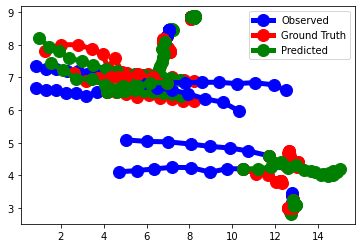

out's shape: torch.Size([23, 2])
observed 1 shape: (8, 23, 2)
target1 shape: (12, 23, 2)
out 1 shape (8, 23, 2)
out2 shape (16, 23, 2)


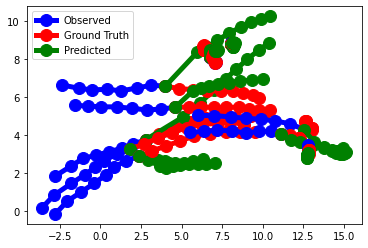

In [ ]:
visualizeLSTM()